In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
meas_data = pd.read_sql('SELECT * FROM Measurement', conn)
stat_data = pd.read_sql('SELECT * FROM Station', conn)
stat_data.head()
meas_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
inspector = inspect(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


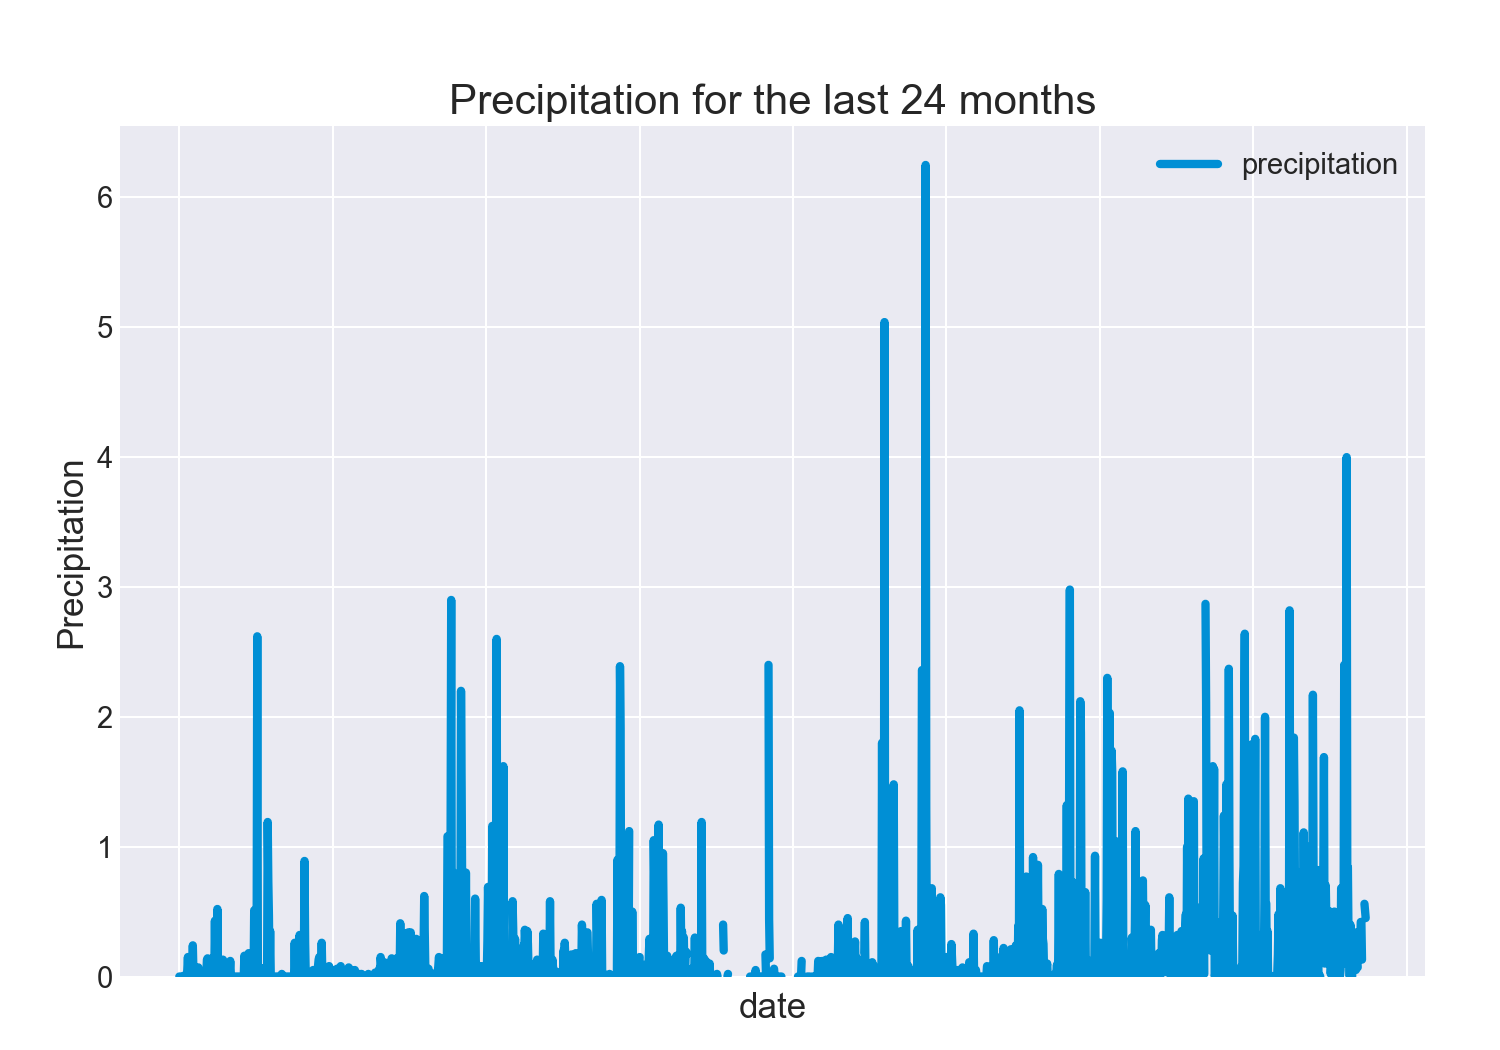

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 2 years ago from today
query_date = dt.date.today() - dt.timedelta(days=730)  

# Perform a query to retrieve the data and precipitation scores
last_2year = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date > query_date)

# Unpack the `dates` and `prcp` from results and save into separate lists
OneYearDates = [r[0] for r in last_2year]
OneYearPrcp = [r[1] for r in last_2year]

# Save the query results as a Pandas DataFrame and set the index to the date column

last_2year_df = pd.DataFrame({'date':OneYearDates,'precipitation':OneYearPrcp})
last_2year_df.set_index('date',inplace=True)

# Sort the dataframe by date
last_2year_df.sort_values(by=['date'])
last_2year_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,7))
last_2year_df.plot(ax=ax)

# Rotate the xticks for the dates
#set major ticks format
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylim(0,max(last_2year_df['precipitation']+.3))
ax.set_title("Precipitation for the last 24 months")
ax.set_ylabel("Precipitation")
ax.set_xlabel("date")
plt.xticks(rotation=45)
plt.savefig("precipitation_last_24_months.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_2year_df.describe()

,precipitation
count,1752.000000
mean,0.160234
std,0.421136
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


In [14]:
# How many stations are available in this dataset?
NumStation = session.query(Measurement).group_by(Measurement.station).count()

#double check using Stations table
NumStation1 = session.query(Station).group_by(Station.station).count()
print(f"{NumStation} stations from Measurement table and {NumStation1} stations from Station table")

9 stations from Measurement table and 9 stations from Station table


In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
Active = session.query(Measurement.station, Station.name, func.count(Measurement.date)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).statement

#write into DataFrame
Active_df = pd.read_sql_query(Active, session.bind)

#Most Active Stations Number
ASNum = Active_df["station"][0]
#Most Active Stations Name
AS = Active_df['name'][0]
#highest number of observation
ASC = Active_df['count_1'][0]

print(f"Station #{ASNum}-'{AS}' has the highest number of observations: {ASC}.")

# List the full list of stations
Active_df

Station #USC00519281-'WAIHEE 837.5, HI US' has the highest number of observations: 2772.


,station,name,count_1
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [135]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

Temps = session.query(Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == ASNum).statement


temps_df = pd.read_sql_query(Temps, session.bind)
temps_df.head()

temp_summary = {'Max': temps_df.max(), 'Min': temps_df.min(), 'Avg': temps_df.mean()}
temp_summary

{'Max': tobs    83.0
 dtype: float64, 'Min': tobs    59.0
 dtype: float64, 'Avg': tobs    72.424837
 dtype: float64}

<IPython.core.display.Javascript object>


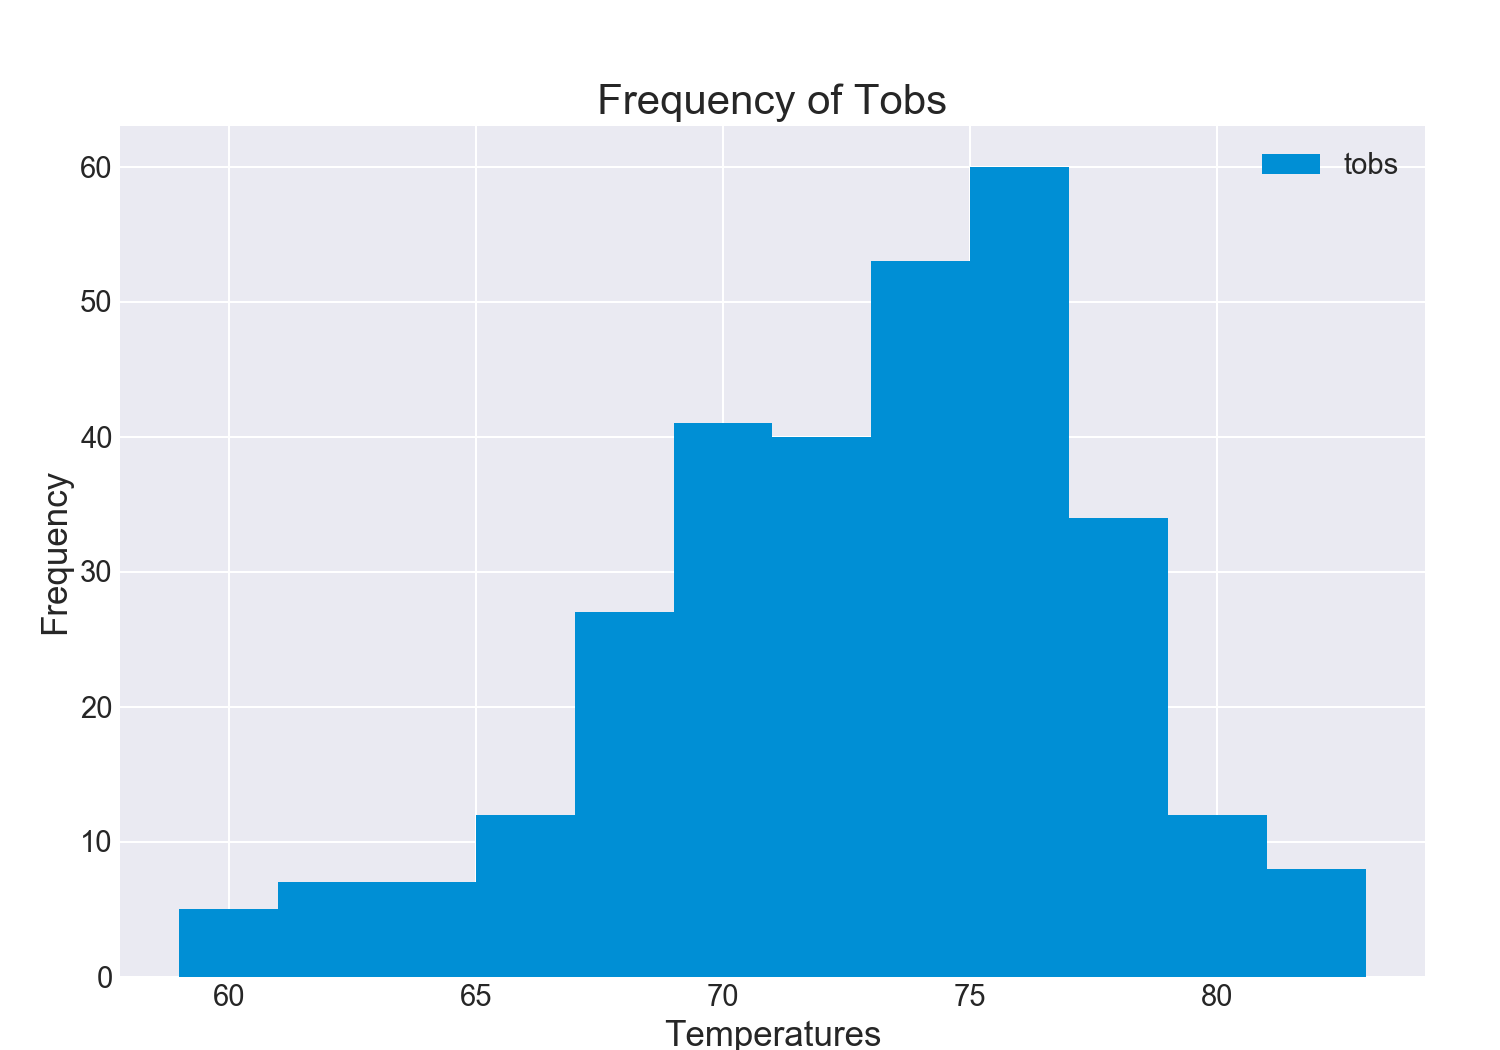

In [72]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sns.set_style(style="darkgrid")
ax = temps_df.plot(kind="hist",bins=12,figsize=(10,7))

ax.set_title("Frequency of Tobs")
ax.set_ylabel("Frequency")
ax.set_xlabel("Temperatures")
plt.savefig("3b.frequency_of_the_tobs.png")
plt.show()

In [89]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.avg(Measurement.tobs),func.max(Measurement.tobs),func.min(Measurement.tobs)).\
        filter(Measurement.date > start_date).filter(Measurement.date < end_date).all()
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

print(calc_temps('2012-02-28', '2012-03-05'))

[(70.325, 74.0, 65.0)]


In [122]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates. Trip dates: 2017-09-01 through 2017-09-15

TempStat = calc_temps('2016-09-01', '2016-09-15')
tempstat_df = pd.DataFrame(TempStat, columns=['avg', 'max', 'min'])
tempstat_df

,avg,max,min
0,77.3625,84.0,71.0


<IPython.core.display.Javascript object>


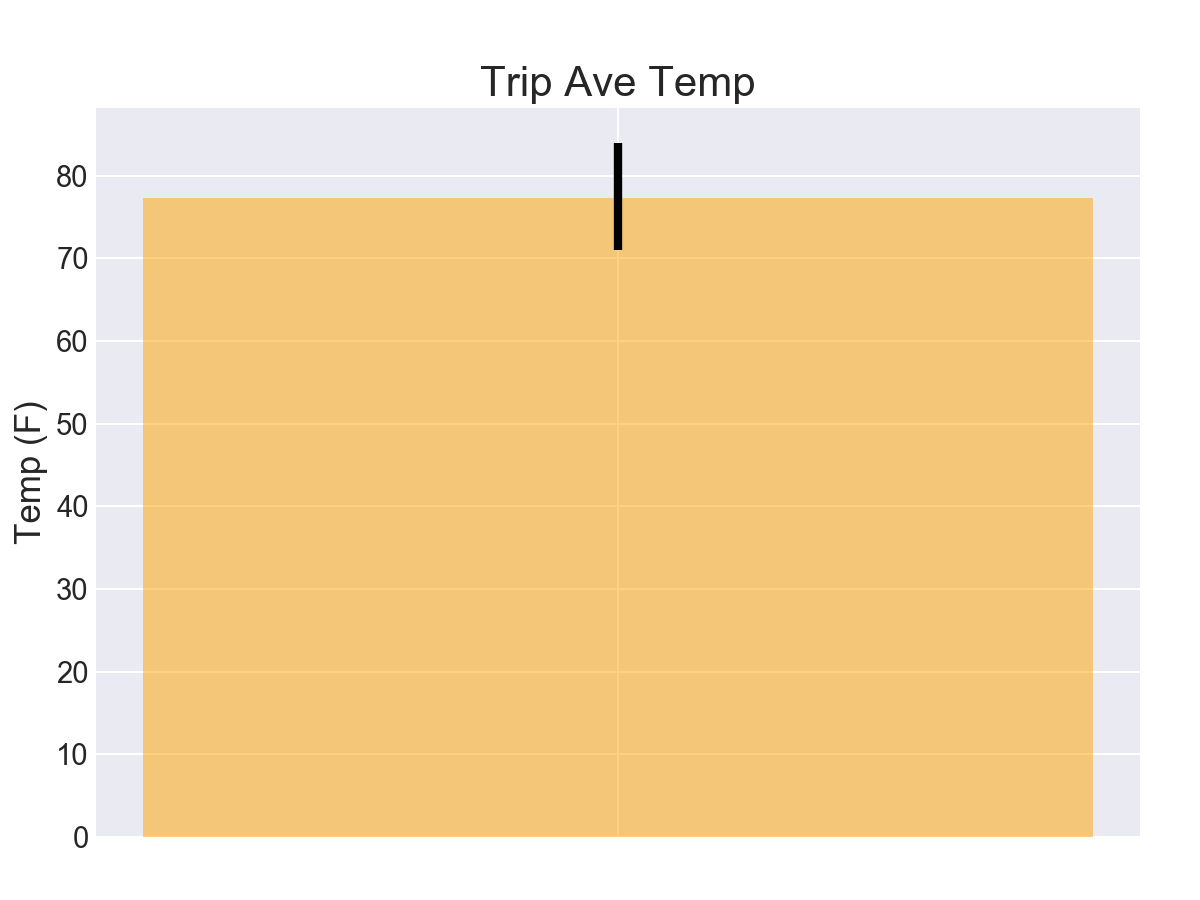

In [131]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

TAve = tempstat_df['avg']
TMax = tempstat_df['max']
TMin = tempstat_df['min']
 
x = np.arange(1,2)
sns.set_style(style="darkgrid")
width =0.1
plt.figure(figsize=(8,6))
plt.bar(x,TAve,width,linewidth=10,alpha=0.5, tick_label="", color="orange",yerr=(TAve-TMin,TMax-TAve))

plt.title("Trip Ave Temp")

plt.ylabel("Temp (F)")
plt.savefig("3c.Trip_Ave_Temp.png")
plt.show()

In [168]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


Prec = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date > '2016-09-01').filter(Measurement.date > '2016-09-15').\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).statement

prec_df = pd.read_sql_query(Prec, session.bind)
prec_df.head()

,station,prcp,name,latitude,longitude,elevation
0,USC00516128,0.45,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519523,0.08,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00513117,0.00,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00514830,0.00,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


## Optional Challenge Assignment

In [169]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [210]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2017-09-01"
end_date = "2017-09-15"

# Use the start and end date to create a range of dates
rng = pd.date_range(start_date, end_date)
rng = rng(func.strftime("%m-%d"))
rng_df = pd.DataFrame(rng)
#rng_df = rng_df.astype(str).str[:5]

#rng_daymonth = str(rng).str[5:]
# Stip off the year and save a list of %m-%d strings

#rng_daymonth = rng.to_datetime(format='%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date


TypeError: 'DatetimeIndex' object is not callable

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


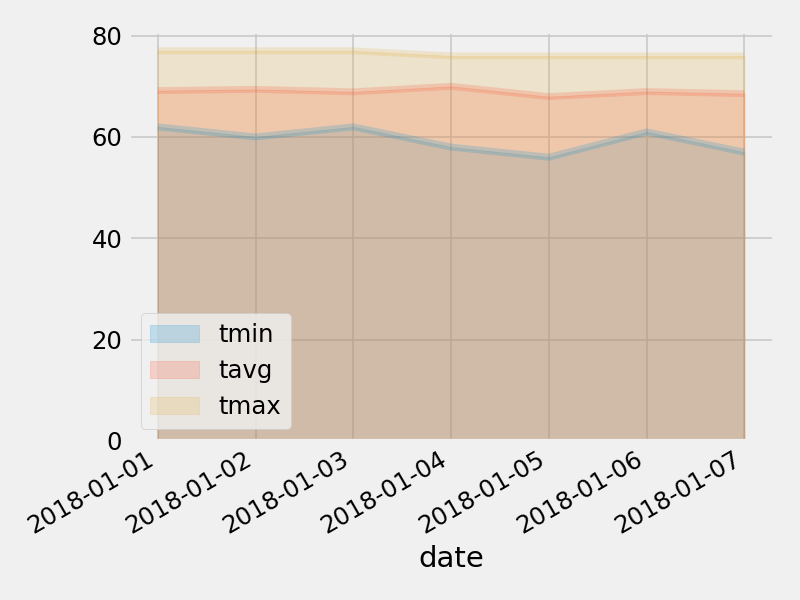

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
